In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import sys
import warnings
warnings.filterwarnings('ignore')


In [2]:
landslides = pd.read_csv('data\Global_Landslide_Catalog_Export.csv', sep=';')
landslides.head()

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
0,AGU,https://blogs.agu.org/landslideblog/2008/10/14...,684,08/01/2008 12:00:00 AM,NaN,"Sigou Village, Loufan County, Shanxi Province","occurred early in morning, 11 villagers buried...","Sigou Village, Loufan County, Shanxi Province",unknown,landslide,...,CN,Shaanxi,0,Jingyang,41.02145,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,107.4500,32.5625
1,Oregonian,http://www.oregonlive.com/news/index.ssf/2009/...,956,01/02/2009 02:00:00 AM,NaN,"Lake Oswego, Oregon",Hours of heavy rain are to blame for an overni...,"Lake Oswego, Oregon",5km,mudslide,...,US,Oregon,"36,619",Lake Oswego,0.60342,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-122.6630,45.4200
2,CBS News,https://www.cbsnews.com/news/dozens-missing-af...,973,01/19/2007 12:00:00 AM,NaN,"San Ramon district, 195 miles northeast of the...",(CBS/AP) At least 10 people died and as many a...,"San Ramon district, 195 miles northeast of the...",10km,landslide,...,PE,Junín,"14,708",San Ramón,0.85548,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-75.3587,-11.1295
3,Reuters,https://in.reuters.com/article/idINIndia-41450...,"1,067",07/31/2009 12:00:00 AM,NaN,Dailekh district,"One person was killed in Dailekh district, pol...",Dailekh district,unknown,landslide,...,NP,Mid Western,"20,908",Dailekh,0.75395,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,81.7080,28.8378
4,The Freeman,http://www.philstar.com/cebu-news/621414/lands...,"2,603",10/16/2010 12:00:00 PM,NaN,sitio Bakilid in barangay Lahug,Another landslide in sitio Bakilid in barangay...,sitio Bakilid in barangay Lahug,5km,landslide,...,PH,Central Visayas,"798,634",Cebu City,2.02204,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,123.8978,10.3336


In [3]:
# We will use a machine learning model to predict fatality counts for landslides. 
# The input features will be the landslide size, landslide trigger, admin division population, gazeteer distance to nearest city, localisation (longitude + lattitude)
# The output feature will be the fatality count

# We will first use a random forest regressor model

# create a new dataframe with the features and the output

landslides_df = landslides[['landslide_size', 'landslide_trigger', 'admin_division_population', 'gazeteer_distance', 'latitude', 'longitude', 'fatality_count']]
landslides_df.head()

,landslide_size,landslide_trigger,admin_division_population,gazeteer_distance,latitude,longitude,fatality_count
0,large,rain,0,41.02145,32.5625,107.4500,11
1,small,downpour,"36,619",0.60342,45.4200,-122.6630,0
2,large,downpour,"14,708",0.85548,-11.1295,-75.3587,10
3,medium,monsoon,"20,908",0.75395,28.8378,81.7080,1
4,medium,tropical_cyclone,"798,634",2.02204,10.3336,123.8978,0


In [4]:
# print data types
landslides_df.dtypes

landslide_size                object
landslide_trigger             object
admin_division_population     object
gazeteer_distance            float64
latitude                     float64
longitude                    float64
fatality_count                object
dtype: object

In [5]:
# show missing values
landslides_df.isnull().sum()



landslide_size                  9
landslide_trigger              23
admin_division_population    1562
gazeteer_distance            1562
latitude                        0
longitude                       0
fatality_count               1385
dtype: int64

In [6]:
# drop rows with missing values
landslides_df = landslides_df.dropna()

# show missing values
landslides_df.isnull().sum()

landslide_size               0
landslide_trigger            0
admin_division_population    0
gazeteer_distance            0
latitude                     0
longitude                    0
fatality_count               0
dtype: int64

In [7]:
# convert admin division population to int (replace comma with nothing)
landslides_df['admin_division_population'] = landslides_df['admin_division_population'].str.replace(',', '')
landslides_df['admin_division_population'] = landslides_df['admin_division_population'].astype(int)

# same for fatality count
landslides_df['fatality_count'] = landslides_df['fatality_count'].str.replace(',', '')
landslides_df['fatality_count'] = landslides_df['fatality_count'].astype(int)

landslides_df.dtypes

print("shape: ", landslides_df.shape)


shape:  (8132, 7)


In [8]:
# Convertir les variables catégorielles en variables one-hot
landslides_df = pd.get_dummies(landslides_df, columns=['landslide_size', 'landslide_trigger'])

# Afficher les premières lignes du nouveau dataframe
landslides_df.head()

,admin_division_population,gazeteer_distance,latitude,longitude,fatality_count,landslide_size_large,landslide_size_medium,landslide_size_small,landslide_size_unknown,landslide_size_very_large,...,landslide_trigger_freeze_thaw,landslide_trigger_mining,landslide_trigger_monsoon,landslide_trigger_no_apparent_trigger,landslide_trigger_other,landslide_trigger_rain,landslide_trigger_snowfall_snowmelt,landslide_trigger_tropical_cyclone,landslide_trigger_unknown,landslide_trigger_volcano
0,0,41.02145,32.5625,107.4500,11,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,36619,0.60342,45.4200,-122.6630,0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,14708,0.85548,-11.1295,-75.3587,10,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,20908,0.75395,28.8378,81.7080,1,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,798634,2.02204,10.3336,123.8978,0,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [9]:
# normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
landslides_df[['admin_division_population', 'gazeteer_distance', 'latitude', 'longitude']] = scaler.fit_transform(landslides_df[['admin_division_population', 'gazeteer_distance', 'latitude', 'longitude']])
landslides_df.head()


,admin_division_population,gazeteer_distance,latitude,longitude,fatality_count,landslide_size_large,landslide_size_medium,landslide_size_small,landslide_size_unknown,landslide_size_very_large,...,landslide_trigger_freeze_thaw,landslide_trigger_mining,landslide_trigger_monsoon,landslide_trigger_no_apparent_trigger,landslide_trigger_other,landslide_trigger_rain,landslide_trigger_snowfall_snowmelt,landslide_trigger_tropical_cyclone,landslide_trigger_unknown,landslide_trigger_volcano
0,0.000000,0.205674,0.664454,0.794522,11,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.002885,0.003025,0.772136,0.137451,0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.001159,0.004289,0.298531,0.272525,10,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.001647,0.003780,0.633259,0.721018,1,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,0.062925,0.010138,0.478286,0.841488,0,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [10]:
landslides_df.dtypes

admin_division_population                    float64
gazeteer_distance                            float64
latitude                                     float64
longitude                                    float64
fatality_count                                 int32
landslide_size_large                            bool
landslide_size_medium                           bool
landslide_size_small                            bool
landslide_size_unknown                          bool
landslide_size_very_large                       bool
landslide_trigger_construction                  bool
landslide_trigger_continuous_rain               bool
landslide_trigger_dam_embankment_collapse       bool
landslide_trigger_downpour                      bool
landslide_trigger_earthquake                    bool
landslide_trigger_flooding                      bool
landslide_trigger_freeze_thaw                   bool
landslide_trigger_mining                        bool
landslide_trigger_monsoon                     

<Axes: >

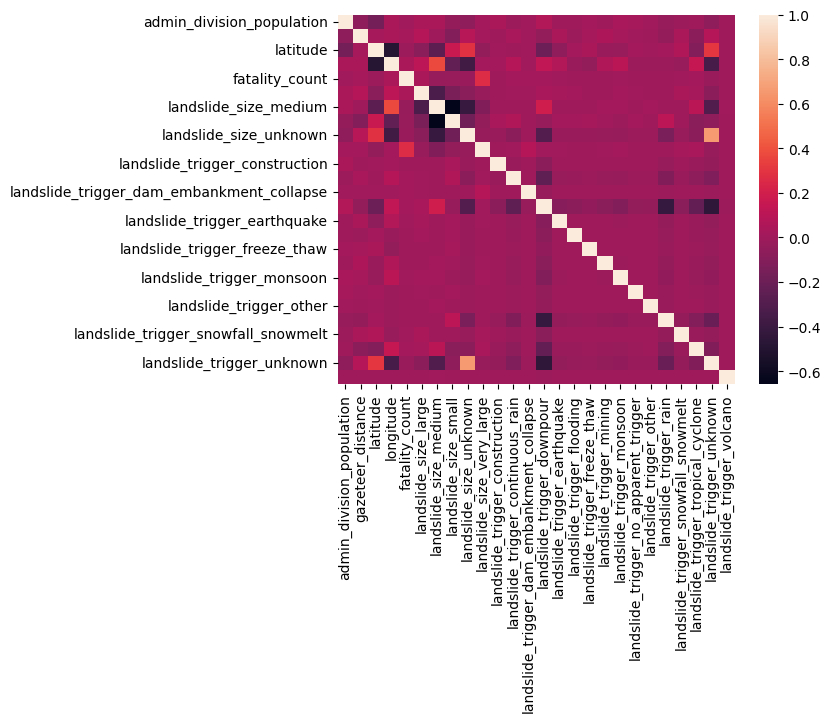

In [11]:
# print correlation matrix
corr = landslides_df.corr()
corr.style.background_gradient(cmap='rocket')

# plot correlation heatmap
sns.heatmap(corr, cmap='rocket', annot=False)



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Séparer les features (X) et la variable cible (y)
X = landslides_df.drop('fatality_count', axis=1)
y = landslides_df['fatality_count']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle de forêt aléatoire
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
rf_model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = rf_model.predict(X_test)

# Évaluer les performances du modèle
mse_RF = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_RF}')

Mean Squared Error: 2699.912262793177


In [13]:
# Afficher les 10 premières valeurs prédites et les valeurs réelles

for i in range(10):
    print(f'Predicted value: {y_pred[i]:.2f} - Actual value: {y_test.values[i]}')

Predicted value: 0.00 - Actual value: 0
Predicted value: 3.75 - Actual value: 9
Predicted value: 0.22 - Actual value: 1
Predicted value: 14.85 - Actual value: 0
Predicted value: 0.06 - Actual value: 0
Predicted value: 1.64 - Actual value: 0
Predicted value: 0.00 - Actual value: 0
Predicted value: 0.11 - Actual value: 0
Predicted value: 0.00 - Actual value: 0
Predicted value: 0.13 - Actual value: 0


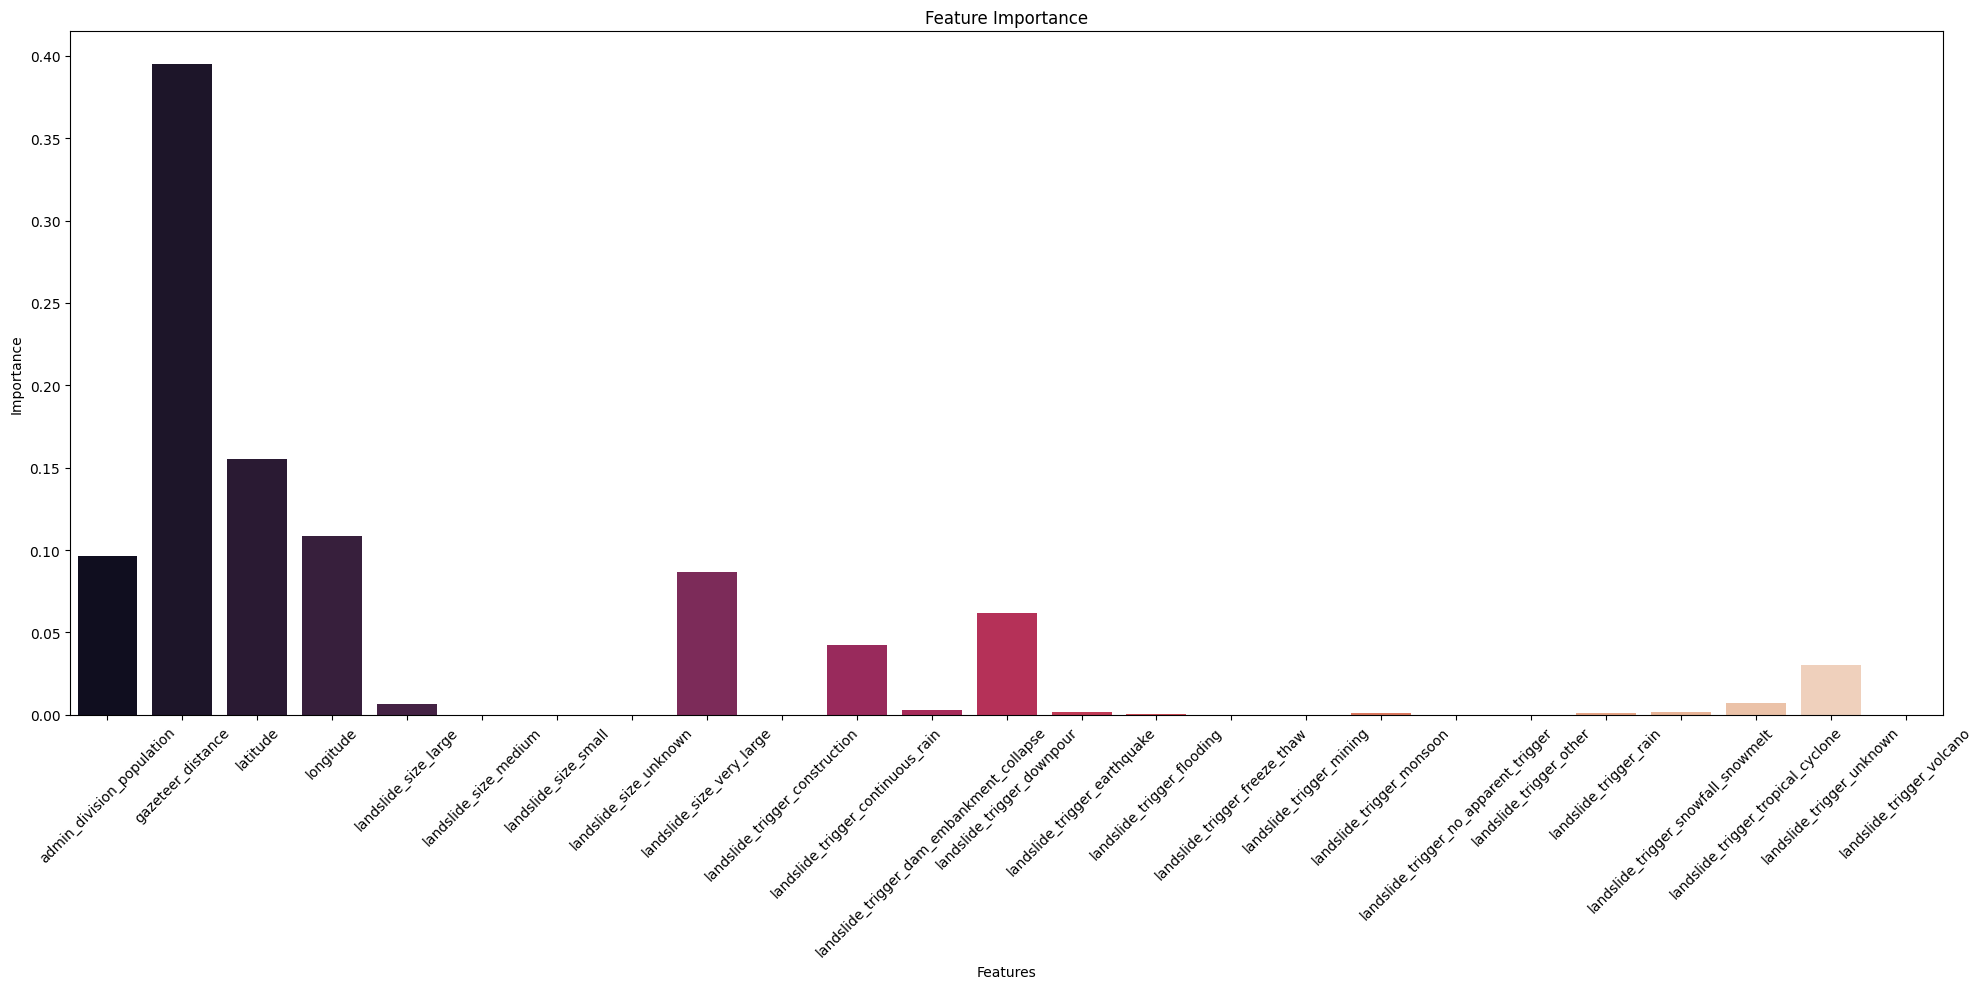

In [14]:
# plot feature importance
plt.figure(figsize=(20, 10))
sns.barplot(x=X.columns, y=rf_model.feature_importances_, palette="rocket")
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [15]:
# plot hyperparameters of the model
from pprint import pprint

pprint(rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [16]:
# hyperparameter tuning with grid search

from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à tester

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialiser le modèle de forêt aléatoire
rf_model = RandomForestRegressor(random_state=42)

# Initialiser la recherche sur grille avec les hyperparamètres à tester
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Entraîner le modèle sur les données d'entraînement
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [17]:
# Afficher les meilleurs hyperparamètres
print(grid_search.best_params_)

# Faire des prédictions sur les données de test
y_pred = grid_search.predict(X_test)

# Évaluer les performances du modèle
mse_RF_tuned = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_RF_tuned}')

{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 1862.280284286824


In [18]:
# Afficher les 10 premières valeurs prédites et les valeurs réelles
for i in range(10):
    print(f'Predicted value: {y_pred[i]:.2f} - Actual value: {y_test.values[i]}')

Predicted value: 0.21 - Actual value: 0
Predicted value: 3.70 - Actual value: 9
Predicted value: 2.74 - Actual value: 1
Predicted value: 6.95 - Actual value: 0
Predicted value: 0.99 - Actual value: 0
Predicted value: 2.08 - Actual value: 0
Predicted value: 7.71 - Actual value: 0
Predicted value: 1.29 - Actual value: 0
Predicted value: 0.20 - Actual value: 0
Predicted value: 0.32 - Actual value: 0


### 2. SVR


In [19]:
# do the same with a SVR model

from sklearn.svm import SVR

# create the model
svr_model = SVR()

# train the model
svr_model.fit(X_train, y_train)

# make predictions
y_pred = svr_model.predict(X_test)

# evaluate the model
mse_SVR = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_SVR}')

# Afficher les 10 premières valeurs prédites et les valeurs réelles
for i in range(10):
    print(f'Predicted value: {y_pred[i]:.2f} - Actual value: {y_test.values[i]}')

    



Mean Squared Error: 2098.261188670919
Predicted value: -0.06 - Actual value: 0
Predicted value: 0.10 - Actual value: 9
Predicted value: 0.32 - Actual value: 1
Predicted value: 1.13 - Actual value: 0
Predicted value: 0.10 - Actual value: 0
Predicted value: 0.10 - Actual value: 0
Predicted value: 0.04 - Actual value: 0
Predicted value: 0.10 - Actual value: 0
Predicted value: -0.06 - Actual value: 0
Predicted value: 0.07 - Actual value: 0


In [20]:
# hyperparameter tuning with grid search

from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à tester

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Initialiser le modèle SVR
svr_model = SVR()

# Initialiser la recherche sur grille avec les hyperparamètres à tester
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Entraîner le modèle sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print(grid_search.best_params_)

# Faire des prédictions sur les données de test
y_pred = grid_search.predict(X_test)

# Évaluer les performances du modèle
mse_SVR_tuned = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_SVR_tuned}')

# Afficher les 10 premières valeurs prédites et les valeurs réelles
for i in range(10):
    print(f'Predicted value: {y_pred[i]:.2f} - Actual value: {y_test.values[i]}')

    

Fitting 3 folds for each of 32 candidates, totalling 96 fits
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Squared Error: 2053.7224404772574
Predicted value: -0.09 - Actual value: 0
Predicted value: 0.12 - Actual value: 9
Predicted value: -0.15 - Actual value: 1
Predicted value: 0.01 - Actual value: 0
Predicted value: 0.04 - Actual value: 0
Predicted value: 0.10 - Actual value: 0
Predicted value: 0.03 - Actual value: 0
Predicted value: 0.10 - Actual value: 0
Predicted value: -0.09 - Actual value: 0
Predicted value: -0.41 - Actual value: 0


In [21]:
# do the same with a linear regression model

from sklearn.linear_model import LinearRegression

# create the model
linear_model = LinearRegression()

# train the model
linear_model.fit(X_train, y_train)

# make predictions
y_pred = linear_model.predict(X_test)

# evaluate the model
mse_LR = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_LR}')

# Afficher les 10 premières valeurs prédites et les valeurs réelles
for i in range(10):
    print(f'Predicted value: {y_pred[i]:.2f} - Actual value: {y_test.values[i]}')

    

Mean Squared Error: 1842.0930009219421
Predicted value: -1.75 - Actual value: 0
Predicted value: 7.19 - Actual value: 9
Predicted value: -3.06 - Actual value: 1
Predicted value: 12.44 - Actual value: 0
Predicted value: -2.75 - Actual value: 0
Predicted value: 4.00 - Actual value: 0
Predicted value: 2.44 - Actual value: 0
Predicted value: 4.94 - Actual value: 0
Predicted value: -2.12 - Actual value: 0
Predicted value: -3.44 - Actual value: 0


In [22]:
# do the same with a neural network model

from sklearn.neural_network import MLPRegressor

# create the model
mlp_model = MLPRegressor(random_state=42)

# train the model
mlp_model.fit(X_train, y_train)

# make predictions
y_pred = mlp_model.predict(X_test)

# evaluate the model
mse_NN = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_NN}')

# Afficher les 10 premières valeurs prédites et les valeurs réelles
for i in range(10):
    print(f'Predicted value: {y_pred[i]:.2f} - Actual value: {y_test.values[i]}')

Mean Squared Error: 1747.2554729125184
Predicted value: 0.23 - Actual value: 0
Predicted value: 1.44 - Actual value: 9
Predicted value: 1.20 - Actual value: 1
Predicted value: 17.65 - Actual value: 0
Predicted value: -0.71 - Actual value: 0
Predicted value: 1.61 - Actual value: 0
Predicted value: -0.37 - Actual value: 0
Predicted value: 1.39 - Actual value: 0
Predicted value: 0.15 - Actual value: 0
Predicted value: 0.34 - Actual value: 0


**Tensorflow Model**




Epoch 1/100


163/163 - 1s - loss: 5025.0386 - mae: 4.0170 - mse: 5025.0386 - val_loss: 3634.1106 - val_mae: 5.0317 - val_mse: 3634.1106 - 1s/epoch - 6ms/step
Epoch 2/100
163/163 - 0s - loss: 5002.9126 - mae: 4.0414 - mse: 5002.9126 - val_loss: 3603.9048 - val_mae: 5.5745 - val_mse: 3603.9048 - 188ms/epoch - 1ms/step
Epoch 3/100
163/163 - 0s - loss: 4984.9238 - mae: 4.2502 - mse: 4984.9238 - val_loss: 3574.9604 - val_mae: 4.8812 - val_mse: 3574.9604 - 182ms/epoch - 1ms/step
Epoch 4/100
163/163 - 0s - loss: 4966.6187 - mae: 4.2478 - mse: 4966.6187 - val_loss: 3544.9536 - val_mae: 4.7752 - val_mse: 3544.9536 - 191ms/epoch - 1ms/step
Epoch 5/100
163/163 - 0s - loss: 4943.1162 - mae: 4.2626 - mse: 4943.1162 - val_loss: 3509.5535 - val_mae: 4.9526 - val_mse: 3509.5535 - 185ms/epoch - 1ms/step
Epoch 6/100
163/163 - 0s - loss: 4914.1182 - mae: 4.2818 - mse: 4914.1182 - val_loss: 3470.9707 - val_mae: 4.9316 - val_mse: 3470.9707 - 180ms/epoch - 1ms/step
Epoch 7/100
163/163 - 0s - loss: 4883.3

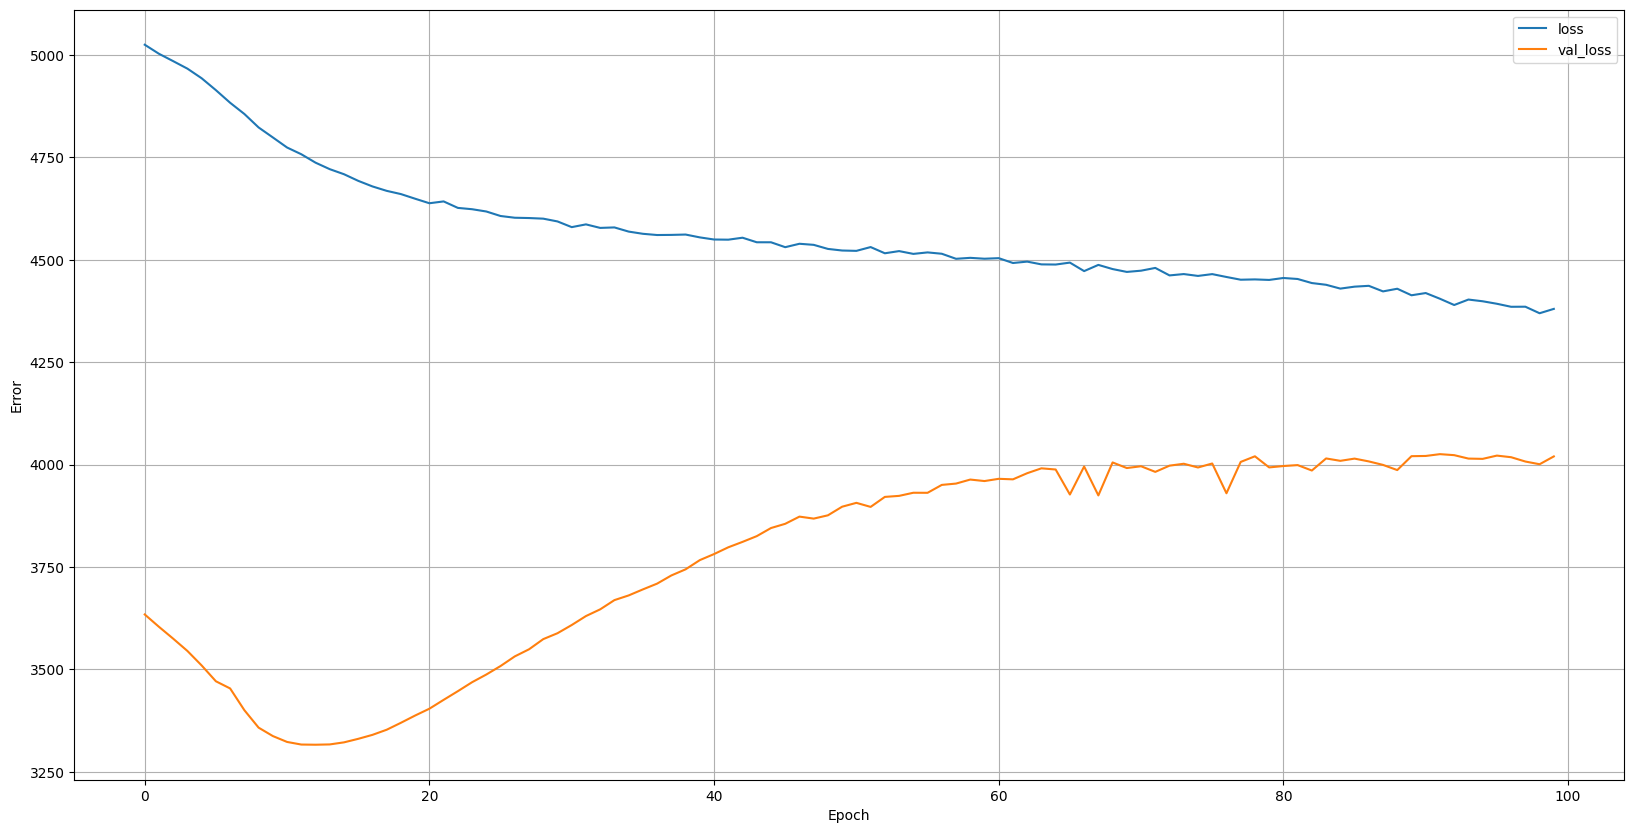

In [23]:
# create the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

# change the data type
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

# train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=2)

# plot the loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# make predictions
y_pred = model.predict(X_test)

# evaluate the model
mse_TF = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_TF}')

# Afficher les 10 premières valeurs prédites et les valeurs réelles
for i in range(10):
    print(f'Predicted value: {y_pred[i][0]:.2f} - Actual value: {y_test.values[i]}')
    

51/51 [==============================] - 0s 769us/step
Mean Squared Error: 1763.0284266317626
Predicted value: -0.86 - Actual value: 0.0
Predicted value: -1.11 - Actual value: 9.0
Predicted value: -0.03 - Actual value: 1.0
Predicted value: 23.81 - Actual value: 0.0
Predicted value: -0.55 - Actual value: 0.0
Predicted value: 0.69 - Actual value: 0.0
Predicted value: -0.97 - Actual value: 0.0
Predicted value: 0.62 - Actual value: 0.0
Predicted value: -0.86 - Actual value: 0.0
Predicted value: -0.21 - Actual value: 0.0


In [25]:
# xgboost model

import xgboost as xgb

# create the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions
y_pred = xgb_model.predict(X_test)

# evaluate the model
mse_XGB = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_XGB}')

# Afficher les 10 premières valeurs prédites et les valeurs réelles
for i in range(10):
    print(f'Predicted value: {y_pred[i]:.2f} - Actual value: {y_test.values[i]}')

Mean Squared Error: 2133.6844826695947
Predicted value: 0.51 - Actual value: 0.0
Predicted value: 3.00 - Actual value: 9.0
Predicted value: 0.63 - Actual value: 1.0
Predicted value: 12.18 - Actual value: 0.0
Predicted value: -0.02 - Actual value: 0.0
Predicted value: 1.22 - Actual value: 0.0
Predicted value: -0.02 - Actual value: 0.0
Predicted value: 0.65 - Actual value: 0.0
Predicted value: -0.08 - Actual value: 0.0
Predicted value: 0.00 - Actual value: 0.0


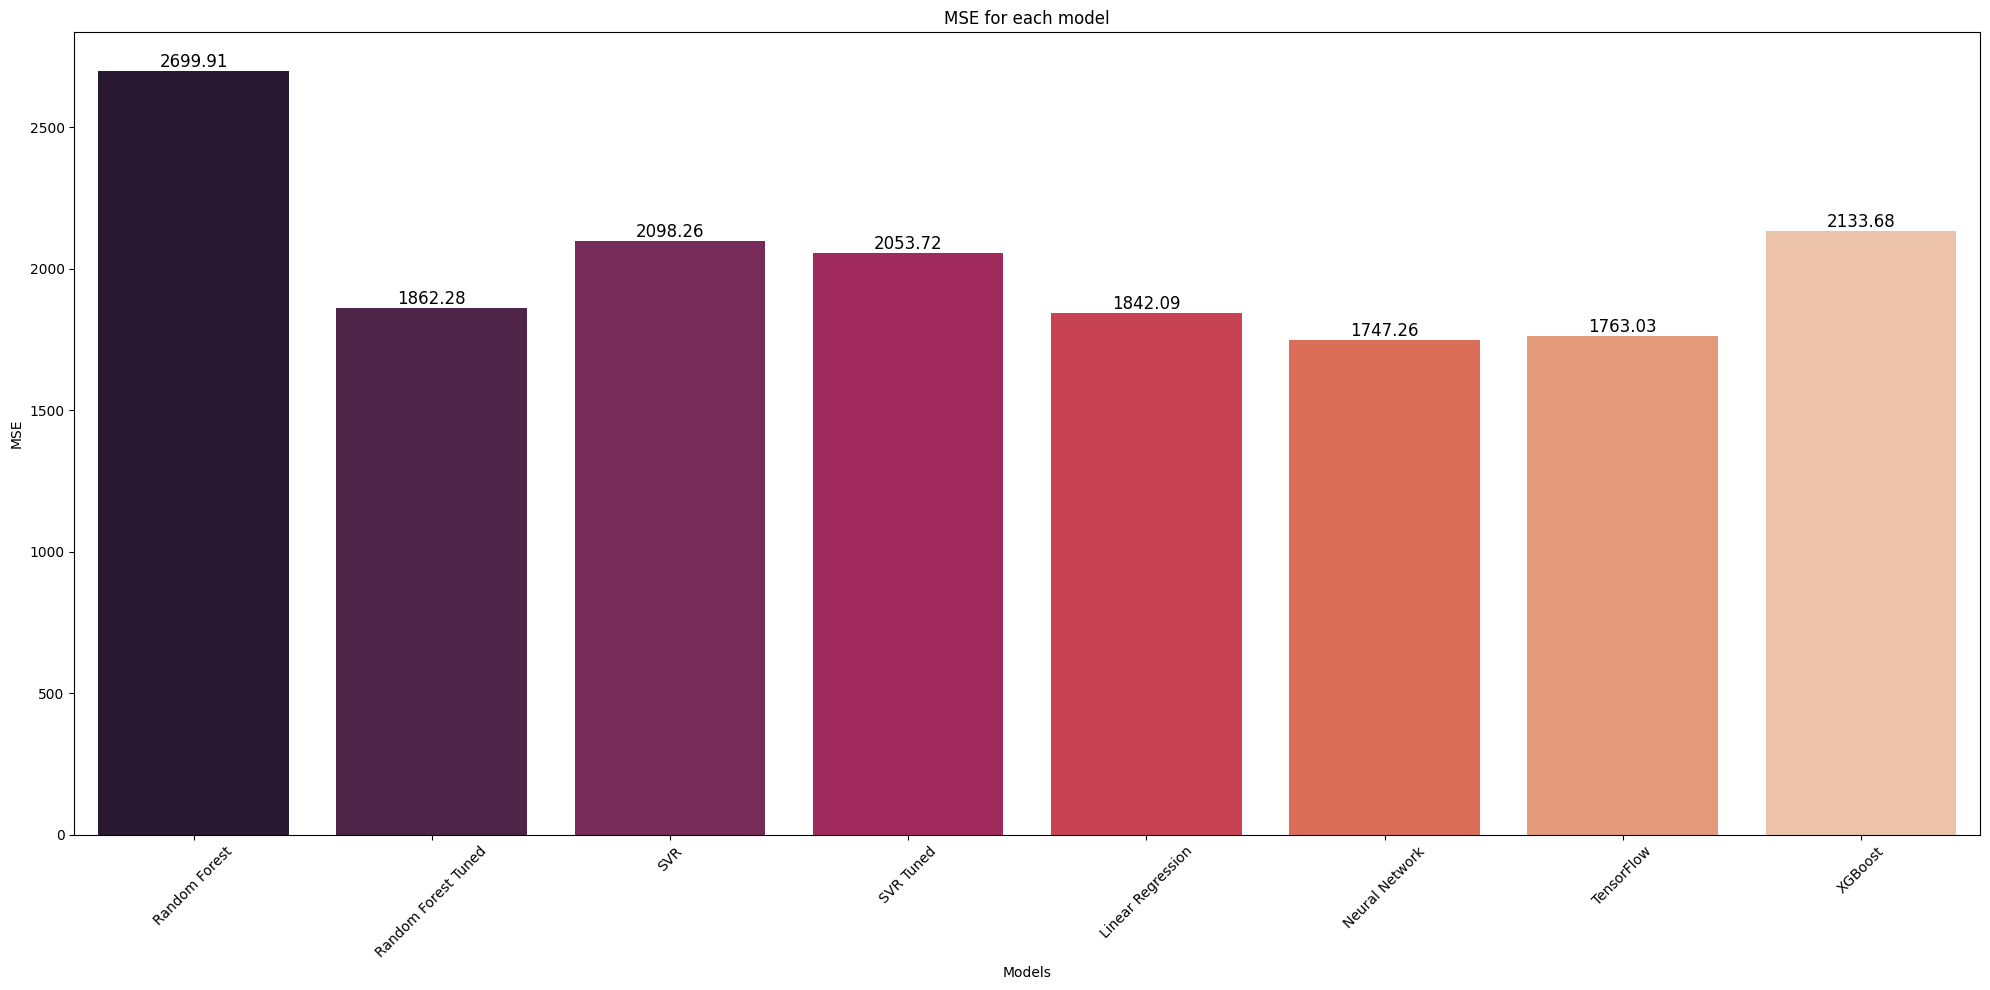

In [26]:
# plot the mse for each model

mse_list = [mse_RF, mse_RF_tuned, mse_SVR, mse_SVR_tuned, mse_LR, mse_NN, mse_TF, mse_XGB]

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=['Random Forest', 'Random Forest Tuned', 'SVR', 'SVR Tuned', 'Linear Regression', 'Neural Network', 'TensorFlow', 'XGBoost'], y=mse_list, palette="rocket")
# for i in ax.containers:
#     ax.bar_label(i,)
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=12)
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('MSE for each model')
plt.tight_layout()
plt.show()